<a href="https://colab.research.google.com/github/jacgonzalez/Graph_Art/blob/main/src/stippling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stippling Application 

In [15]:
!git clone https://github.com/RoboTums/PyTSPArt.git
!mv PyTSPArt/code/voronoi.py .

fatal: destination path 'PyTSPArt' already exists and is not an empty directory.
mv: cannot stat 'PyTSPArt/code/voronoi.py': No such file or directory


In [16]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [ ]:
uploaded

In [ ]:
list(uploaded.keys())[0]

In [ ]:
from IPython.display import Image
Image(filename=list(uploaded.keys())[0]) 

In [26]:
# This code was adapted from: https://github.com/RoboTums/PyTSPArt/blob/master/code/stippler.py
#! /usr/bin/env python3
# -----------------------------------------------------------------------------
# Weighted Voronoi Stippler
# Copyright (2017) Nicolas P. Rougier - BSD license
#
# Implementation of:
#   Weighted Voronoi Stippling, Adrian Secord
#   Symposium on Non-Photorealistic Animation and Rendering (NPAR), 2002
# -----------------------------------------------------------------------------
# Some usage examples
#
# stippler.py boots.jpg --save --force --n_point 20000 --n_iter 50
#                       --pointsize 0.5 2.5 --figsize 8 --interactive
# stippler.py plant.png --save --force --n_point 20000 --n_iter 50
#                       --pointsize 0.5 1.5 --figsize 8
# stippler.py gradient.png --save --force --n_point 5000 --n_iter 50
#                          --pointsize 1.0 1.0 --figsize 6
# -----------------------------------------------------------------------------
# usage: stippler.py [-h] [--n_iter n] [--n_point n] [--epsilon n]
#                    [--pointsize min,max) (min,max] [--figsize w,h] [--force]
#                    [--save] [--display] [--interactive]
#                    image filename
#
# Weighted Vororonoi Stippler
#
# positional arguments:
#   image filename        Density image filename
#
# optional arguments:
#   -h, --help            show this help message and exit
#   --n_iter n            Maximum number of iterations
#   --n_point n           Number of points
#   --epsilon n           Early stop criterion
#   --pointsize (min,max) (min,max)
#                         Point mix/max size for final display
#   --figsize w,h         Figure size
#   --force               Force recomputation
#   --save                Save computed points
#   --display             Display final result
#   --interactive         Display intermediate results (slower)
# -----------------------------------------------------------------------------
import tqdm
import voronoi
import os.path
import scipy.misc
import scipy.ndimage
import numpy as np
import imageio
import matplotlib.pyplot as plt

def normalize(D):
    Vmin, Vmax = D.min(), D.max()
    if Vmax - Vmin > 1e-5:
        D = (D-Vmin)/(Vmax-Vmin)
    else:
        D = np.zeros_like(D)
    return D


def initialization(n, D):
    """
    Return n points distributed over [xmin, xmax] x [ymin, ymax]
    according to (normalized) density distribution.
    with xmin, xmax = 0, density.shape[1]
         ymin, ymax = 0, density.shape[0]
    The algorithm here is a simple rejection sampling.
    """

    samples = []
    while len(samples) < n:
        # X = np.random.randint(0, D.shape[1], 10*n)
        # Y = np.random.randint(0, D.shape[0], 10*n)
        X = np.random.uniform(0, D.shape[1], 10*n)
        Y = np.random.uniform(0, D.shape[0], 10*n)
        P = np.random.uniform(0, 1, 10*n)
        index = 0
        while index < len(X) and len(samples) < n:
            x, y = X[index], Y[index]
            x_, y_ = int(np.floor(x)), int(np.floor(y))
            if P[index] < D[y_, x_]:
                samples.append([x, y])
            index += 1
    return np.array(samples)

def stippler(filename,
            n_point = 5000,
            n_iter = 50,
            threshold = 255,
            force = False,
            save = False,
            display = False,
            interactive = False):

    density = imageio.imread(filename, as_gray=True, pilmode='L')

    # We want (approximately) 500 pixels per voronoi region
    zoom = (n_point * 500) / (density.shape[0]*density.shape[1])
    zoom = int(round(np.sqrt(zoom)))
    density = scipy.ndimage.zoom(density, zoom, order=0)
    # Apply threshold onto image
    # Any color > threshold will be white
    density = np.minimum(density, threshold)

    density = 1.0 - normalize(density)
    density = density[::-1, :]
    density_P = density.cumsum(axis=1)
    density_Q = density_P.cumsum(axis=1)

    dirname = os.path.dirname(filename)
    basename = (os.path.basename(filename).split('.'))[0]
    pdf_filename = os.path.join(dirname, basename + "_stipple.pdf")
    png_filename = os.path.join(dirname, basename + "_stipple.png")
    dat_filename = os.path.join(dirname, basename + "_stipple.npy")

    # Initialization
    points = initialization(n_point, density)
    print("Nb points:", n_point)
    print("Nb iterations:", n_iter)

    print("Density file: %s (resized to %dx%d)" % (
          filename, density.shape[1], density.shape[0]))

    for i in tqdm.trange(n_iter):
        regions, points = voronoi.centroids(points, density, density_P, density_Q)
       
    return points, density

def visualize(points, density, pointsize = (1.0, 1.0), figsize = 6):
    # Visualize points
    xmin, xmax = 0, density.shape[1]
    ymin, ymax = 0, density.shape[0]
    bbox = np.array([xmin, xmax, ymin, ymax])
    ratio = (xmax-xmin)/(ymax-ymin)
    
    fig = plt.figure(figsize=(figsize, figsize/ratio),
                    facecolor="white")
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax.set_xlim([xmin, xmax])
    ax.set_xticks([])
    ax.set_ylim([ymin, ymax])
    ax.set_yticks([])
    scatter = ax.scatter(points[:, 0], points[:, 1], s=1, 
                          facecolor="k", edgecolor="None")
    Pi = points.astype(int)
    X = np.maximum(np.minimum(Pi[:, 0], density.shape[1]-1), 0)
    Y = np.maximum(np.minimum(Pi[:, 1], density.shape[0]-1), 0)
    sizes = (pointsize[0] +
              (pointsize[1]-pointsize[0])*density[Y, X])
    scatter.set_offsets(points)
    scatter.set_sizes(sizes)

    plt.show()

    # Plot voronoi regions if you want
    # for region in vor.filtered_regions:
    #     vertices = vor.vertices[region, :]
    #     ax.plot(vertices[:, 0], vertices[:, 1], linewidth=.5, color='.5' )

In [22]:
points, density = stippler(list(uploaded.keys())[0], n_point=500)

Nb points: 500
Nb iterations: 50
Density file: 1_pWeHwkrkGWZcEQMgNEygPQ.jpeg (resized to 512x512)


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


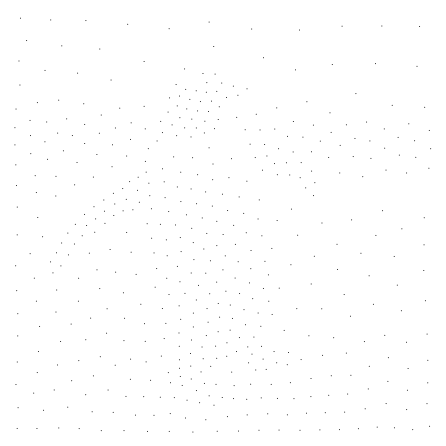

In [27]:
visualize(points, density)

In [28]:
points

array([[137.74294007, 173.01896919],
       [142.80859204, 491.27526541],
       [ 84.39347789, 163.10804587],
       [ 58.65980739, 176.34256395],
       [106.41420843, 200.238989  ],
       [109.70146439, 178.00376098],
       [128.54910227, 197.50513022],
       [ 10.03552046, 205.0339501 ],
       [ 32.14138885, 190.39246832],
       [ 61.13359143,  12.84690626],
       [ 47.81232538, 331.27239439],
       [162.25610747, 447.21476064],
       [ 83.44039225, 433.37021609],
       [ 61.04755804, 401.35541365],
       [109.73896298, 461.95605237],
       [ 41.9514592 , 239.44767196],
       [ 27.19217281, 219.380356  ],
       [ 71.87051967, 243.81671911],
       [158.39125341, 159.46239067],
       [146.2501841 ,  94.4153333 ],
       [145.99663209,  70.54269687],
       [ 75.77004503, 135.96491131],
       [ 57.6193691 , 287.76475256],
       [ 11.92579741,  91.01240481],
       [ 11.27172187, 175.55065515],
       [ 44.71726832, 351.98232942],
       [ 46.81657425, 375.47616872],
 

In [30]:
points.tolist()

[[137.74294006619627, 173.01896919193436],
 [142.80859203547539, 491.27526540960326],
 [84.39347789462167, 163.10804587081856],
 [58.659807394585336, 176.34256394595766],
 [106.41420843418815, 200.23898900433193],
 [109.7014643884992, 178.00376097582142],
 [128.5491022661217, 197.50513021987857],
 [10.035520461608737, 205.03395010235178],
 [32.14138884624143, 190.39246831729344],
 [61.13359143179948, 12.846906261488048],
 [47.81232538041021, 331.27239438684273],
 [162.25610746931815, 447.2147606425812],
 [83.44039224519571, 433.37021609009275],
 [61.04755804470277, 401.35541365217153],
 [109.73896297589387, 461.95605237014587],
 [41.95145919614923, 239.4476719613258],
 [27.19217280749294, 219.3803559994285],
 [71.87051966959042, 243.81671910637013],
 [158.3912534099241, 159.46239067127433],
 [146.25018409959117, 94.41533330368505],
 [145.99663208722544, 70.54269687181745],
 [75.77004502659854, 135.96491131223243],
 [57.61936909655421, 287.76475256038435],
 [11.925797413357612, 91.01240

In [ ]:
class 